In [23]:
!pip install opencv-python
!pip install matplotlib
!pip install IPython
!pip install opencv-contrib-python --user

  Using cached opencv_contrib_python-4.7.0.68-cp37-abi3-win_amd64.whl (44.9 MB)


In [1]:
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Image

## Prepare image

In [12]:
# Load image from folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [13]:
templates = load_images_from_folder('./templates')
images = load_images_from_folder('./images')

In [14]:
plt.figure(figsize=(16,8))


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

## Local Feature Extraction

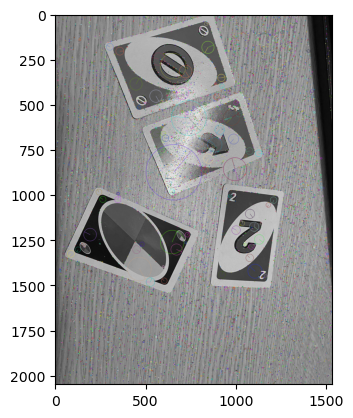

In [15]:
# SIFT
def draw_keypoints_sift(keypoints,image,image_gray):
    final_image=cv2.drawKeypoints(image_gray,keypoints,image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(final_image)
    
def sift_local_feature_extraction(img):
    sift = cv2.SIFT_create() 
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find keypoints, descriptor
    keypoints, descriptors = sift.detectAndCompute(image_gray,None) 
    draw_keypoints_sift(keypoints,img,image_gray)
    dic = dict()
    dic['kp'] = keypoints
    dic['des'] = descriptors
    return dic
    
template_kp_des = sift_local_feature_extraction(templates[2])
image_kp_des = sift_local_feature_extraction(images[2])

## Image Matching

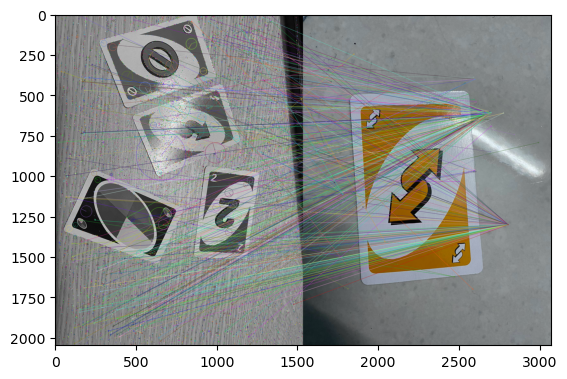

In [16]:
# Brute Force
def bf_image_matching(img1,img2,kp1,kp2,des1,des2,k = 2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    perfects = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
             perfects.append([m])
    # cv2.drawMatchesKnn expects list of lists as matches.
    bf_matching_image = cv2.drawMatchesKnn(img1, kp1, img2, kp2, perfects, None, flags=2)
    # 
    plt.imshow(bf_matching_image), plt.show()
    

bf_image_matching(images[2],templates[1],image_kp_des['kp'],template_kp_des['kp'],image_kp_des['des'],template_kp_des['des'])

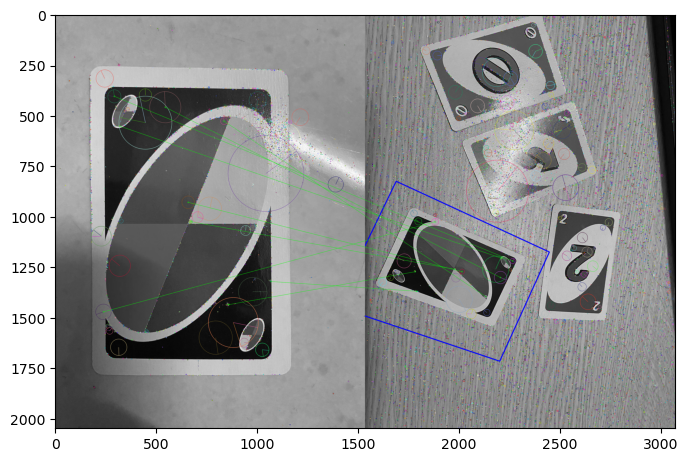

In [17]:
# FLANN
def flann_image_matching(img1,img2,kp1,kp2,des1,des2):
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    
    matches = flann.knnMatch(des1,des2,k=2) # trả về 2 features gần nhất từ tập des2
    matchesMask = [[0,0] for i in range(len(matches))]
    MIN_MATCH_COUNT=10
    good = []
    distance_ratio = 0.7
    for m,n in matches:
        if m.distance < distance_ratio*n.distance: # chỉ giữ lại những ghép cặp ổn định (m.distance: khoảng cách gần nhất, n.distance: khoảng cách gần thứ 2)
            good.append(m)
    ## khoanh vùng đối tượng tương ứng được tìm thấy
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    
        # tìm phép biến đổi đồng dạng giữa 2 tập điểm được so khớp
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) 
    
        matchesMask = mask.ravel().tolist()
        h,w,d = img1.shape
    
        # xác định vị trí tương ứng trên ảnh đích của 4 góc trên ảnh nguồn
    
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # 4 điểm khoanh vùng trên ảnh nguồn
        dst = cv2.perspectiveTransform(pts,M) # thực hiện biến đổi để tìm ra vị trí tương ứng trong ảnh được so khớp
    
        # hiển thị kết quả tương ứng
        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    ## hiển thị kết quả
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img12 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img12, cv2.COLOR_BGR2RGB))
    plt.show()

flann_image_matching(templates[2],images[2],template_kp_des['kp'],image_kp_des['kp'],template_kp_des['des'],image_kp_des['des'])